# Previsão de Viagens de Bicicleta - Ponte Fremont
## Análise com Impacto da Pandemia COVID-19

**Objetivo:** Prever o número de viagens de bicicleta pela Ponte Fremont em Seattle, analisando o impacto da pandemia COVID-19 (março/2020) usando técnicas de regressão e validação holdout.

**Dataset:** Contador de bicicletas na Ponte Fremont, Seattle
**Período:** Dados históricos incluindo pré e pós-pandemia
**Variável adicional:** Indicador binário para início da pandemia (março/2020)

## 1. Importação das Bibliotecas

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 2. Carregamento dos Dados

In [5]:
# URL dos dados da Ponte Fremont
url = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'

print("Carregando dados da Ponte Fremont...")
df = pd.read_csv(url, index_col='Date', parse_dates=True)

# Verificando e ajustando colunas
print(f"Colunas originais: {df.columns.tolist()}")

# O dataset tem 3 colunas, vamos renomear adequadamente
if len(df.columns) == 3:
    df.columns = ['West', 'East', 'Total']
elif len(df.columns) == 2:
    df.columns = ['West', 'East']
    df['Total'] = df['West'] + df['East']
else:
    # Manter nomes originais se estrutura diferente
    print(f"⚠️ Estrutura de {len(df.columns)} colunas detectada")
    # Criar Total se não existir
    if 'Total' not in df.columns:
        df['Total'] = df.iloc[:, 0] + df.iloc[:, 1]

print(f"\n✓ Dados carregados com sucesso!")
print(f"Shape dos dados: {df.shape}")
print(f"Período: {df.index.min()} até {df.index.max()}")
print(f"\nPrimeiras linhas:")
print(df.head())

Carregando dados da Ponte Fremont...
Colunas originais: ['Fremont Bridge Sidewalks, south of N 34th St Total', 'Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk', 'Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk']

✓ Dados carregados com sucesso!
Shape dos dados: (112440, 3)
Período: 2012-10-02 13:00:00 até 2025-07-31 23:00:00

Primeiras linhas:
                      West   East  Total
Date                                    
2012-10-02 13:00:00   55.0    7.0   48.0
2012-10-02 14:00:00  130.0   55.0   75.0
2012-10-02 15:00:00  152.0   81.0   71.0
2012-10-02 16:00:00  278.0  167.0  111.0
2012-10-02 17:00:00  563.0  393.0  170.0
Colunas originais: ['Fremont Bridge Sidewalks, south of N 34th St Total', 'Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk', 'Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk']

✓ Dados carregados com sucesso!
Shape dos dados: (112440, 3)
Período: 2012-10-02 13:00:00 até 2025-07-31 23:00:00

## 3. Análise Exploratória Inicial

In [6]:
# Informações básicas
print("Informações do Dataset:")
print("=" * 70)
print(df.info())
print("\n" + "=" * 70)
print("Estatísticas Descritivas:")
print(df.describe())
print("\n" + "=" * 70)
print(f"Valores ausentes:")
print(df.isnull().sum())

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112440 entries, 2012-10-02 13:00:00 to 2025-07-31 23:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   West    111908 non-null  float64
 1   East    111908 non-null  float64
 2   Total   111908 non-null  float64
dtypes: float64(3)
memory usage: 3.4 MB
None

Estatísticas Descritivas:
                West           East          Total
count  111908.000000  111908.000000  111908.000000
mean      106.552043      45.422803      61.129240
std       131.828247      59.025699      82.423448
min         0.000000       0.000000       0.000000
25%        13.000000       5.000000       7.000000
50%        60.000000      26.000000      33.000000
75%       146.000000      63.000000      81.000000
max      1097.000000     667.000000     850.000000

Valores ausentes:
West     532
East     532
Total    532
dtype: int64


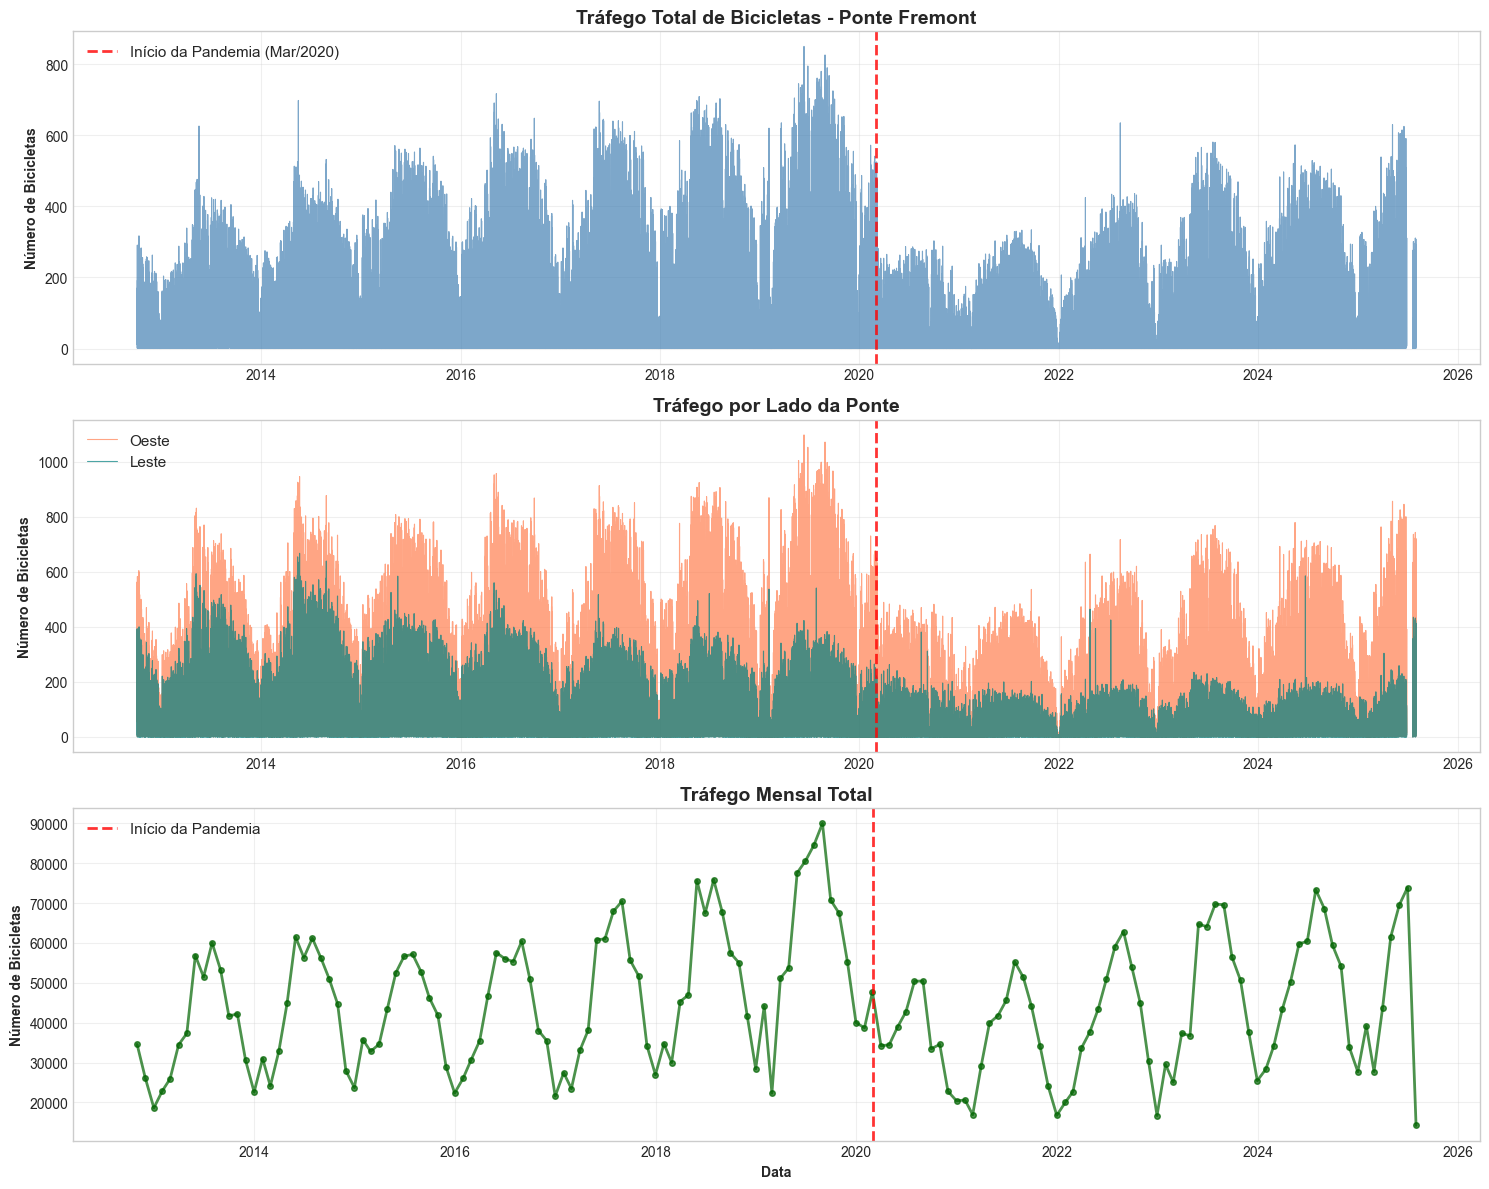

In [7]:
# Visualização da série temporal
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Gráfico 1: Série temporal completa
axes[0].plot(df.index, df['Total'], color='steelblue', linewidth=0.8, alpha=0.7)
axes[0].axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', linewidth=2, 
                label='Início da Pandemia (Mar/2020)', alpha=0.8)
axes[0].set_title('Tráfego Total de Bicicletas - Ponte Fremont', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Número de Bicicletas', fontweight='bold')
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Comparação Leste vs Oeste
axes[1].plot(df.index, df['West'], label='Oeste', color='coral', linewidth=0.8, alpha=0.7)
axes[1].plot(df.index, df['East'], label='Leste', color='teal', linewidth=0.8, alpha=0.7)
axes[1].axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', linewidth=2, alpha=0.8)
axes[1].set_title('Tráfego por Lado da Ponte', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Número de Bicicletas', fontweight='bold')
axes[1].legend(loc='upper left', fontsize=11)
axes[1].grid(True, alpha=0.3)

# Gráfico 3: Média móvel mensal
df_monthly = df.resample('M').sum()
axes[2].plot(df_monthly.index, df_monthly['Total'], marker='o', 
             linewidth=2, markersize=4, color='darkgreen', alpha=0.7)
axes[2].axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', 
                linewidth=2, label='Início da Pandemia', alpha=0.8)
axes[2].set_title('Tráfego Mensal Total', fontweight='bold', fontsize=14)
axes[2].set_ylabel('Número de Bicicletas', fontweight='bold')
axes[2].set_xlabel('Data', fontweight='bold')
axes[2].legend(loc='upper left', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Engenharia de Features

In [8]:
# Criando features temporais
print("Criando features temporais...")

# Resetando o índice para trabalhar com a coluna de data
df_features = df.copy()
df_features['date'] = df_features.index

# Features temporais básicas
df_features['hour'] = df_features['date'].dt.hour
df_features['day'] = df_features['date'].dt.day
df_features['month'] = df_features['date'].dt.month
df_features['year'] = df_features['date'].dt.year
df_features['dayofweek'] = df_features['date'].dt.dayofweek  # 0=Segunda, 6=Domingo
df_features['dayofyear'] = df_features['date'].dt.dayofyear

# Features cíclicas (para capturar a natureza cíclica do tempo)
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
df_features['dayofweek_sin'] = np.sin(2 * np.pi * df_features['dayofweek'] / 7)
df_features['dayofweek_cos'] = np.cos(2 * np.pi * df_features['dayofweek'] / 7)

# Features categóricas
df_features['is_weekend'] = (df_features['dayofweek'] >= 5).astype(int)
df_features['is_rush_hour'] = ((df_features['hour'] >= 7) & (df_features['hour'] <= 9) | 
                                (df_features['hour'] >= 16) & (df_features['hour'] <= 18)).astype(int)

# **FEATURE PRINCIPAL: Indicador de pandemia (a partir de março/2020)**
df_features['pandemic'] = (df_features['date'] >= pd.Timestamp('2020-03-01')).astype(int)

# Removendo a coluna de data auxiliar
df_features = df_features.drop('date', axis=1)

print(f"✓ Features criadas com sucesso!")
print(f"\nShape final: {df_features.shape}")
print(f"\nColunas disponíveis:")
print(df_features.columns.tolist())

Criando features temporais...
✓ Features criadas com sucesso!

Shape final: (112440, 18)

Colunas disponíveis:
['West', 'East', 'Total', 'hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'is_weekend', 'is_rush_hour', 'pandemic']


In [9]:
# Visualizando o impacto da pandemia
print("Análise do Impacto da Pandemia:")
print("=" * 70)

pre_pandemic = df_features[df_features['pandemic'] == 0]['Total']
post_pandemic = df_features[df_features['pandemic'] == 1]['Total']

print(f"\nPré-Pandemia (antes de Mar/2020):")
print(f"  Registros: {len(pre_pandemic):,}")
print(f"  Média diária: {pre_pandemic.mean():.2f} bicicletas")
print(f"  Mediana: {pre_pandemic.median():.2f} bicicletas")
print(f"  Desvio padrão: {pre_pandemic.std():.2f}")

print(f"\nPós-Pandemia (a partir de Mar/2020):")
print(f"  Registros: {len(post_pandemic):,}")
print(f"  Média diária: {post_pandemic.mean():.2f} bicicletas")
print(f"  Mediana: {post_pandemic.median():.2f} bicicletas")
print(f"  Desvio padrão: {post_pandemic.std():.2f}")

diff_percent = ((post_pandemic.mean() - pre_pandemic.mean()) / pre_pandemic.mean()) * 100
print(f"\nVariação percentual: {diff_percent:+.2f}%")
print("=" * 70)

Análise do Impacto da Pandemia:

Pré-Pandemia (antes de Mar/2020):
  Registros: 64,955
  Média diária: 63.03 bicicletas
  Mediana: 32.00 bicicletas
  Desvio padrão: 89.50

Pós-Pandemia (a partir de Mar/2020):
  Registros: 47,485
  Média diária: 58.51 bicicletas
  Mediana: 34.00 bicicletas
  Desvio padrão: 71.41

Variação percentual: -7.17%


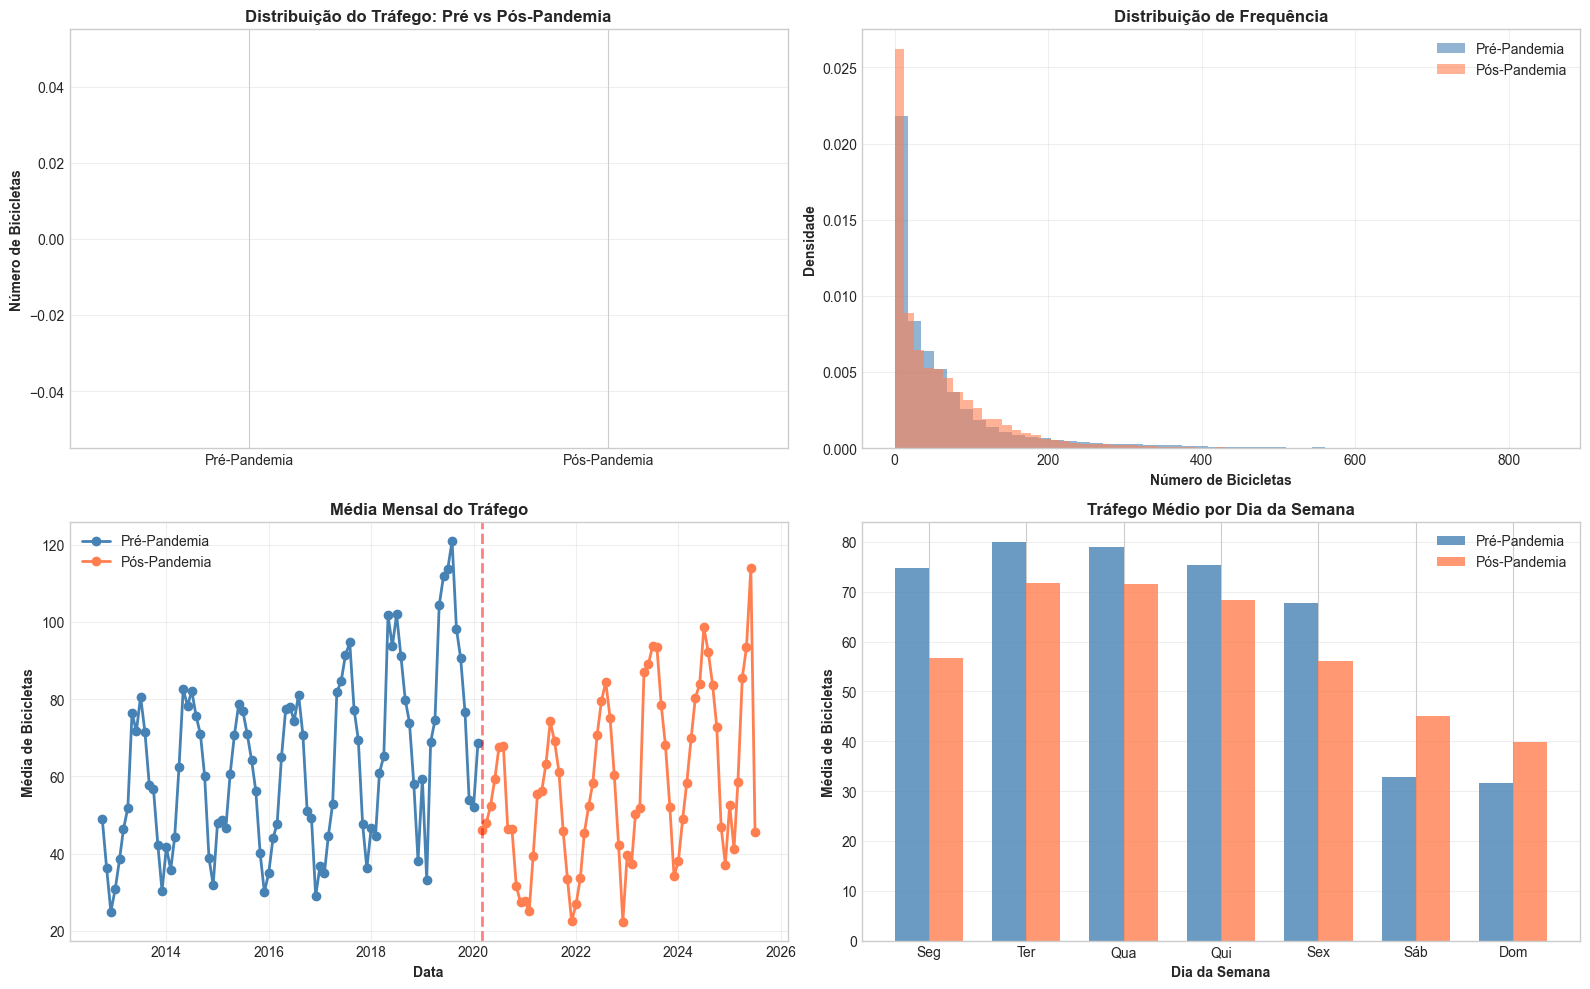

In [10]:
# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Boxplot comparativo
axes[0, 0].boxplot([pre_pandemic, post_pandemic], 
                    labels=['Pré-Pandemia', 'Pós-Pandemia'],
                    patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
axes[0, 0].set_title('Distribuição do Tráfego: Pré vs Pós-Pandemia', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Número de Bicicletas', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Histograma comparativo
axes[0, 1].hist(pre_pandemic, bins=50, alpha=0.6, label='Pré-Pandemia', color='steelblue', density=True)
axes[0, 1].hist(post_pandemic, bins=50, alpha=0.6, label='Pós-Pandemia', color='coral', density=True)
axes[0, 1].set_title('Distribuição de Frequência', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Número de Bicicletas', fontweight='bold')
axes[0, 1].set_ylabel('Densidade', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Média por mês
df_monthly_pandemic = df_features.groupby([df_features.index.to_period('M'), 'pandemic'])['Total'].mean().reset_index()
df_monthly_pandemic['date'] = df_monthly_pandemic['Date'].dt.to_timestamp()
pre_monthly = df_monthly_pandemic[df_monthly_pandemic['pandemic'] == 0]
post_monthly = df_monthly_pandemic[df_monthly_pandemic['pandemic'] == 1]

axes[1, 0].plot(pre_monthly['date'], pre_monthly['Total'], 
                marker='o', label='Pré-Pandemia', color='steelblue', linewidth=2)
axes[1, 0].plot(post_monthly['date'], post_monthly['Total'], 
                marker='o', label='Pós-Pandemia', color='coral', linewidth=2)
axes[1, 0].axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[1, 0].set_title('Média Mensal do Tráfego', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Média de Bicicletas', fontweight='bold')
axes[1, 0].set_xlabel('Data', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Tráfego por dia da semana
weekday_traffic = df_features.groupby(['dayofweek', 'pandemic'])['Total'].mean().reset_index()
days = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']

pre_weekday = weekday_traffic[weekday_traffic['pandemic'] == 0]['Total'].values
post_weekday = weekday_traffic[weekday_traffic['pandemic'] == 1]['Total'].values

x = np.arange(len(days))
width = 0.35

axes[1, 1].bar(x - width/2, pre_weekday, width, label='Pré-Pandemia', color='steelblue', alpha=0.8)
axes[1, 1].bar(x + width/2, post_weekday, width, label='Pós-Pandemia', color='coral', alpha=0.8)
axes[1, 1].set_title('Tráfego Médio por Dia da Semana', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('Média de Bicicletas', fontweight='bold')
axes[1, 1].set_xlabel('Dia da Semana', fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(days)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Preparação dos Dados para Modelagem

In [11]:
# Removendo valores ausentes
df_clean = df_features.dropna()

print(f"Registros antes da limpeza: {len(df_features):,}")
print(f"Registros após limpeza: {len(df_clean):,}")
print(f"Registros removidos: {len(df_features) - len(df_clean):,}")

# Separando features (X) e target (y)
feature_columns = ['hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear',
                   'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
                   'dayofweek_sin', 'dayofweek_cos',
                   'is_weekend', 'is_rush_hour', 'pandemic']

X = df_clean[feature_columns]
y = df_clean['Total']

print(f"\nShape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")
print(f"\nFeatures utilizadas:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {col}")

Registros antes da limpeza: 112,440
Registros após limpeza: 111,908
Registros removidos: 532

Shape de X (features): (111908, 15)
Shape de y (target): (111908,)

Features utilizadas:
   1. hour
   2. day
   3. month
   4. year
   5. dayofweek
   6. dayofyear
   7. hour_sin
   8. hour_cos
   9. month_sin
  10. month_cos
  11. dayofweek_sin
  12. dayofweek_cos
  13. is_weekend
  14. is_rush_hour
  15. pandemic


## 6. Divisão Holdout (Treino/Teste)

In [13]:
# Divisão holdout: 80% treino, 20% teste
# Usando shuffle=False para manter a ordem temporal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, shuffle=False)

print("Divisão Holdout (80% Treino / 20% Teste):")
print("=" * 70)
print(f"\nConjunto de Treino:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Período: {X_train.index[0]} até {X_train.index[-1]}")

print(f"\nConjunto de Teste:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Período: {X_test.index[0]} até {X_test.index[-1]}")

# Verificando distribuição da variável pandemic
print(f"\nDistribuição da variável 'pandemic' no treino:")
print(f"  Pré-pandemia: {(X_train['pandemic'] == 0).sum():,} ({(X_train['pandemic'] == 0).sum()/len(X_train)*100:.1f}%)")
print(f"  Pós-pandemia: {(X_train['pandemic'] == 1).sum():,} ({(X_train['pandemic'] == 1).sum()/len(X_train)*100:.1f}%)")

print(f"\nDistribuição da variável 'pandemic' no teste:")
print(f"  Pré-pandemia: {(X_test['pandemic'] == 0).sum():,} ({(X_test['pandemic'] == 0).sum()/len(X_test)*100:.1f}%)")
print(f"  Pós-pandemia: {(X_test['pandemic'] == 1).sum():,} ({(X_test['pandemic'] == 1).sum()/len(X_test)*100:.1f}%)")
print("=" * 70)

Divisão Holdout (80% Treino / 20% Teste):

Conjunto de Treino:
  X_train shape: (89526, 15)
  y_train shape: (89526,)
  Período: 2012-10-02 13:00:00 até 2022-12-20 09:00:00

Conjunto de Teste:
  X_test shape: (22382, 15)
  y_test shape: (22382,)
  Período: 2022-12-20 10:00:00 até 2025-07-31 23:00:00

Distribuição da variável 'pandemic' no treino:
  Pré-pandemia: 64,943 (72.5%)
  Pós-pandemia: 24,583 (27.5%)

Distribuição da variável 'pandemic' no teste:
  Pré-pandemia: 0 (0.0%)
  Pós-pandemia: 22,382 (100.0%)


In [14]:
# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Dados normalizados com StandardScaler")
print(f"\nExemplo de valores normalizados (primeiras 5 linhas):")
print(pd.DataFrame(X_train_scaled[:5], columns=feature_columns).round(3))

✓ Dados normalizados com StandardScaler

Exemplo de valores normalizados (primeiras 5 linhas):
    hour    day  month   year  dayofweek  dayofyear  hour_sin  hour_cos  \
0  0.217 -1.559  0.975 -1.813       -1.0      0.849    -0.366    -1.366   
1  0.361 -1.559  0.975 -1.813       -1.0      0.849    -0.707    -1.225   
2  0.505 -1.559  0.975 -1.813       -1.0      0.849    -1.000    -1.000   
3  0.650 -1.559  0.975 -1.813       -1.0      0.849    -1.225    -0.707   
4  0.794 -1.559  0.975 -1.813       -1.0      0.849    -1.366    -0.366   

   month_sin  month_cos  dayofweek_sin  dayofweek_cos  is_weekend  \
0     -1.208      0.684          1.106          0.882      -0.632   
1     -1.208      0.684          1.106          0.882      -0.632   
2     -1.208      0.684          1.106          0.882      -0.632   
3     -1.208      0.684          1.106          0.882      -0.632   
4     -1.208      0.684          1.106          0.882      -0.632   

   is_rush_hour  pandemic  
0        -0

## 7. Treinamento dos Modelos de Regressão

In [15]:
# Definindo os modelos
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

print("Treinando modelos...")
print("=" * 70)

# Dicionário para armazenar resultados
results = {}

# Treinando e avaliando cada modelo
for name, model in models.items():
    print(f"\n[{name}]")
    
    # Treinar o modelo
    model.fit(X_train_scaled, y_train)
    
    # Fazer previsões
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Calcular métricas
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Armazenar resultados
    results[name] = {
        'model': model,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred,
        'y_train_pred': y_train_pred
    }
    
    print(f"  Treino  - RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R²: {train_r2:.4f}")
    print(f"  Teste   - RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R²: {test_r2:.4f}")

print("\n" + "=" * 70)
print("✓ Todos os modelos foram treinados!")

Treinando modelos...

[Linear Regression]
  Treino  - RMSE: 58.12, MAE: 37.06, R²: 0.5009
  Teste   - RMSE: 54.11, MAE: 35.53, R²: 0.5732

[Ridge Regression]
  Treino  - RMSE: 58.12, MAE: 37.05, R²: 0.5008
  Teste   - RMSE: 54.07, MAE: 35.50, R²: 0.5738

[Lasso Regression]
  Treino  - RMSE: 58.30, MAE: 36.32, R²: 0.4978
  Teste   - RMSE: 54.79, MAE: 35.32, R²: 0.5624

[Random Forest]
  Treino  - RMSE: 58.30, MAE: 36.32, R²: 0.4978
  Teste   - RMSE: 54.79, MAE: 35.32, R²: 0.5624

[Random Forest]
  Treino  - RMSE: 8.65, MAE: 4.48, R²: 0.9890
  Teste   - RMSE: 42.41, MAE: 23.48, R²: 0.7377

[Gradient Boosting]
  Treino  - RMSE: 8.65, MAE: 4.48, R²: 0.9890
  Teste   - RMSE: 42.41, MAE: 23.48, R²: 0.7377

[Gradient Boosting]
  Treino  - RMSE: 37.21, MAE: 21.19, R²: 0.7954
  Teste   - RMSE: 43.71, MAE: 25.38, R²: 0.7214

✓ Todos os modelos foram treinados!
  Treino  - RMSE: 37.21, MAE: 21.19, R²: 0.7954
  Teste   - RMSE: 43.71, MAE: 25.38, R²: 0.7214

✓ Todos os modelos foram treinados!


## 8. Comparação dos Resultados (Métricas Holdout)

In [16]:
# Criando DataFrame comparativo
comparison_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'RMSE Treino': [results[m]['train_rmse'] for m in results.keys()],
    'RMSE Teste': [results[m]['test_rmse'] for m in results.keys()],
    'MAE Treino': [results[m]['train_mae'] for m in results.keys()],
    'MAE Teste': [results[m]['test_mae'] for m in results.keys()],
    'R² Treino': [results[m]['train_r2'] for m in results.keys()],
    'R² Teste': [results[m]['test_r2'] for m in results.keys()]
})

print("\n" + "=" * 100)
print("TABELA COMPARATIVA - MÉTRICAS DE DESEMPENHO (HOLDOUT)")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Identificando o melhor modelo
best_model_name = comparison_df.loc[comparison_df['R² Teste'].idxmax(), 'Modelo']
best_r2 = comparison_df['R² Teste'].max()

print(f"\n🏆 MELHOR MODELO: {best_model_name}")
print(f"   R² no conjunto de teste: {best_r2:.4f}")
print("=" * 100)


TABELA COMPARATIVA - MÉTRICAS DE DESEMPENHO (HOLDOUT)
           Modelo  RMSE Treino  RMSE Teste  MAE Treino  MAE Teste  R² Treino  R² Teste
Linear Regression    58.116544   54.109553   37.055050  35.528700   0.500914  0.573175
 Ridge Regression    58.121503   54.066833   37.052060  35.499567   0.500829  0.573849
 Lasso Regression    58.299731   54.785485   36.320931  35.319088   0.497763  0.562444
    Random Forest     8.647236   42.413878    4.482616  23.479564   0.988951  0.737748
Gradient Boosting    37.209812   43.714741   21.194254  25.384368   0.795407  0.721415

🏆 MELHOR MODELO: Random Forest
   R² no conjunto de teste: 0.7377


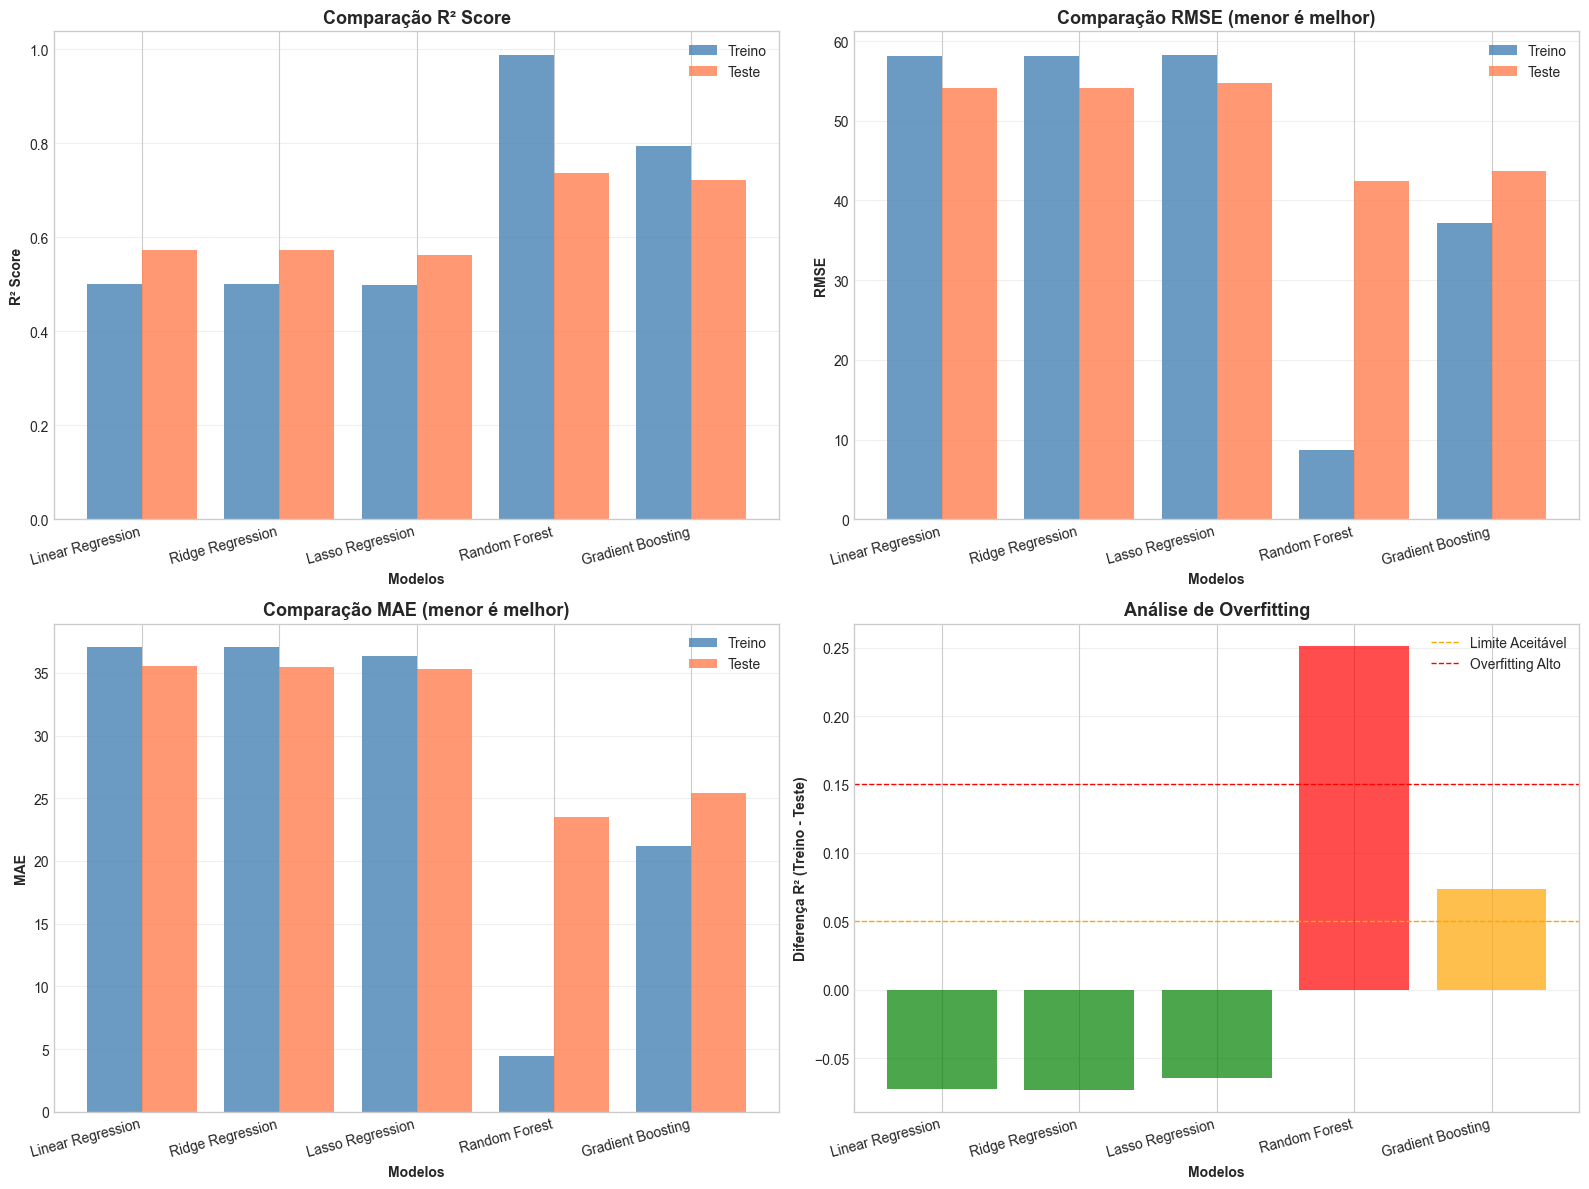

In [17]:
# Visualização comparativa das métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models_list = list(results.keys())
x_pos = np.arange(len(models_list))

# Gráfico 1: R² Score
r2_train = [results[m]['train_r2'] for m in models_list]
r2_test = [results[m]['test_r2'] for m in models_list]

axes[0, 0].bar(x_pos - 0.2, r2_train, 0.4, label='Treino', color='steelblue', alpha=0.8)
axes[0, 0].bar(x_pos + 0.2, r2_test, 0.4, label='Teste', color='coral', alpha=0.8)
axes[0, 0].set_xlabel('Modelos', fontweight='bold')
axes[0, 0].set_ylabel('R² Score', fontweight='bold')
axes[0, 0].set_title('Comparação R² Score', fontweight='bold', fontsize=13)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(models_list, rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Gráfico 2: RMSE
rmse_train = [results[m]['train_rmse'] for m in models_list]
rmse_test = [results[m]['test_rmse'] for m in models_list]

axes[0, 1].bar(x_pos - 0.2, rmse_train, 0.4, label='Treino', color='steelblue', alpha=0.8)
axes[0, 1].bar(x_pos + 0.2, rmse_test, 0.4, label='Teste', color='coral', alpha=0.8)
axes[0, 1].set_xlabel('Modelos', fontweight='bold')
axes[0, 1].set_ylabel('RMSE', fontweight='bold')
axes[0, 1].set_title('Comparação RMSE (menor é melhor)', fontweight='bold', fontsize=13)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(models_list, rotation=15, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Gráfico 3: MAE
mae_train = [results[m]['train_mae'] for m in models_list]
mae_test = [results[m]['test_mae'] for m in models_list]

axes[1, 0].bar(x_pos - 0.2, mae_train, 0.4, label='Treino', color='steelblue', alpha=0.8)
axes[1, 0].bar(x_pos + 0.2, mae_test, 0.4, label='Teste', color='coral', alpha=0.8)
axes[1, 0].set_xlabel('Modelos', fontweight='bold')
axes[1, 0].set_ylabel('MAE', fontweight='bold')
axes[1, 0].set_title('Comparação MAE (menor é melhor)', fontweight='bold', fontsize=13)
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(models_list, rotation=15, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Gráfico 4: Overfitting analysis (diferença entre treino e teste)
r2_diff = [results[m]['train_r2'] - results[m]['test_r2'] for m in models_list]

colors = ['green' if diff < 0.05 else 'orange' if diff < 0.15 else 'red' for diff in r2_diff]
axes[1, 1].bar(x_pos, r2_diff, color=colors, alpha=0.7)
axes[1, 1].axhline(y=0.05, color='orange', linestyle='--', linewidth=1, label='Limite Aceitável')
axes[1, 1].axhline(y=0.15, color='red', linestyle='--', linewidth=1, label='Overfitting Alto')
axes[1, 1].set_xlabel('Modelos', fontweight='bold')
axes[1, 1].set_ylabel('Diferença R² (Treino - Teste)', fontweight='bold')
axes[1, 1].set_title('Análise de Overfitting', fontweight='bold', fontsize=13)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(models_list, rotation=15, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Análise de Importância das Features

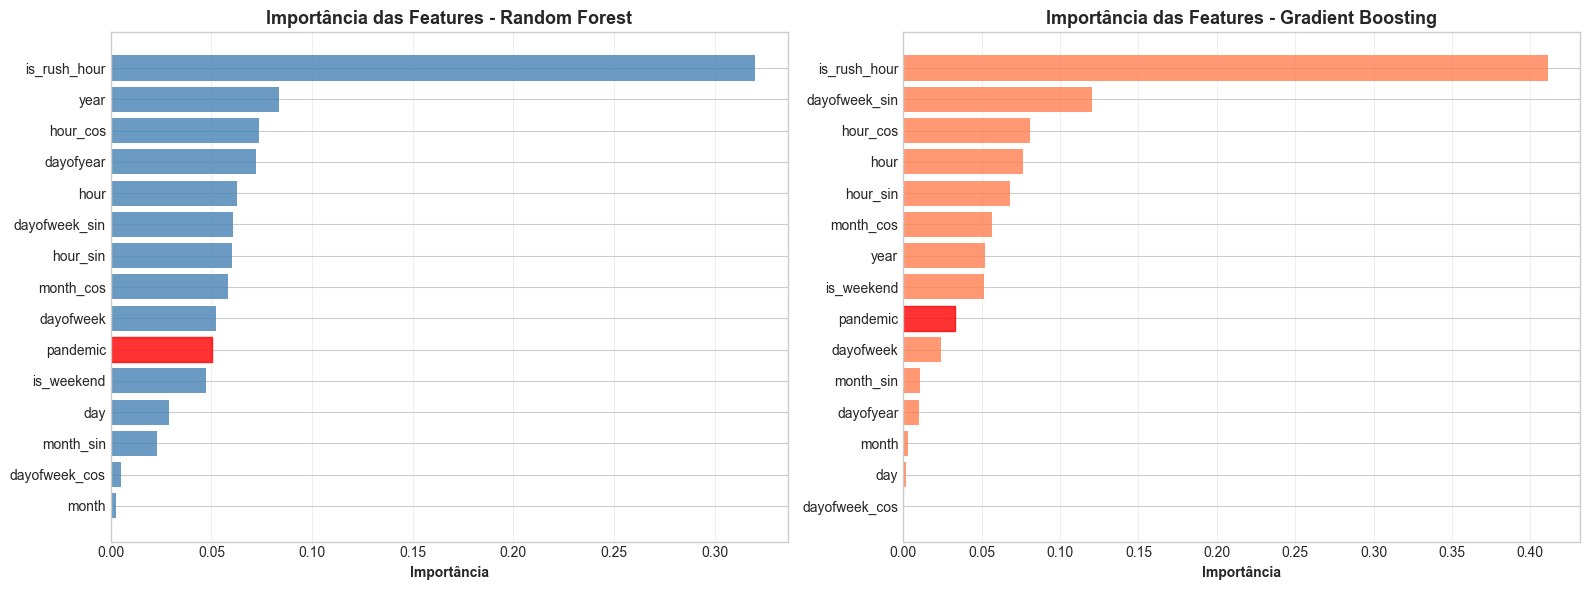


RANKING DE IMPORTÂNCIA DAS FEATURES

Random Forest:
      Feature  Importance
 is_rush_hour    0.320111
         year    0.083760
     hour_cos    0.073545
    dayofyear    0.072326
         hour    0.062607
dayofweek_sin    0.060507
     hour_sin    0.060003
    month_cos    0.058286
    dayofweek    0.052271
     pandemic    0.050075
   is_weekend    0.047127
          day    0.028722
    month_sin    0.023221
dayofweek_cos    0.005040
        month    0.002401

Posição da feature 'pandemic': 15º lugar
Importância: 0.0501

----------------------------------------------------------------------

Gradient Boosting:
      Feature  Importance
 is_rush_hour    0.411110
dayofweek_sin    0.120305
     hour_cos    0.080937
         hour    0.076664
     hour_sin    0.067986
    month_cos    0.056604
         year    0.052109
   is_weekend    0.051634
     pandemic    0.032935
    dayofweek    0.024338
    month_sin    0.010548
    dayofyear    0.010183
        month    0.003185
          day

In [18]:
# Analisando importância das features para Random Forest e Gradient Boosting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
rf_model = results['Random Forest']['model']
rf_importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

axes[0].barh(range(len(rf_importances)), rf_importances['Importance'], color='steelblue', alpha=0.8)
axes[0].set_yticks(range(len(rf_importances)))
axes[0].set_yticklabels(rf_importances['Feature'])
axes[0].set_xlabel('Importância', fontweight='bold')
axes[0].set_title('Importância das Features - Random Forest', fontweight='bold', fontsize=13)
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Destacando a feature 'pandemic'
pandemic_idx = rf_importances[rf_importances['Feature'] == 'pandemic'].index[0]
pandemic_position = rf_importances.index.get_loc(pandemic_idx)
axes[0].get_children()[pandemic_position].set_color('red')
axes[0].get_children()[pandemic_position].set_alpha(0.8)

# Gradient Boosting
gb_model = results['Gradient Boosting']['model']
gb_importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

axes[1].barh(range(len(gb_importances)), gb_importances['Importance'], color='coral', alpha=0.8)
axes[1].set_yticks(range(len(gb_importances)))
axes[1].set_yticklabels(gb_importances['Feature'])
axes[1].set_xlabel('Importância', fontweight='bold')
axes[1].set_title('Importância das Features - Gradient Boosting', fontweight='bold', fontsize=13)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

# Destacando a feature 'pandemic'
pandemic_idx_gb = gb_importances[gb_importances['Feature'] == 'pandemic'].index[0]
pandemic_position_gb = gb_importances.index.get_loc(pandemic_idx_gb)
axes[1].get_children()[pandemic_position_gb].set_color('red')
axes[1].get_children()[pandemic_position_gb].set_alpha(0.8)

plt.tight_layout()
plt.show()

# Mostrando ranking
print("\n" + "=" * 70)
print("RANKING DE IMPORTÂNCIA DAS FEATURES")
print("=" * 70)
print("\nRandom Forest:")
print(rf_importances.to_string(index=False))
print(f"\nPosição da feature 'pandemic': {rf_importances[rf_importances['Feature'] == 'pandemic'].index[0] + 1}º lugar")
print(f"Importância: {rf_importances[rf_importances['Feature'] == 'pandemic']['Importance'].values[0]:.4f}")

print("\n" + "-" * 70)
print("\nGradient Boosting:")
print(gb_importances.to_string(index=False))
print(f"\nPosição da feature 'pandemic': {gb_importances[gb_importances['Feature'] == 'pandemic'].index[0] + 1}º lugar")
print(f"Importância: {gb_importances[gb_importances['Feature'] == 'pandemic']['Importance'].values[0]:.4f}")
print("=" * 70)

## 10. Análise de Previsões vs Valores Reais

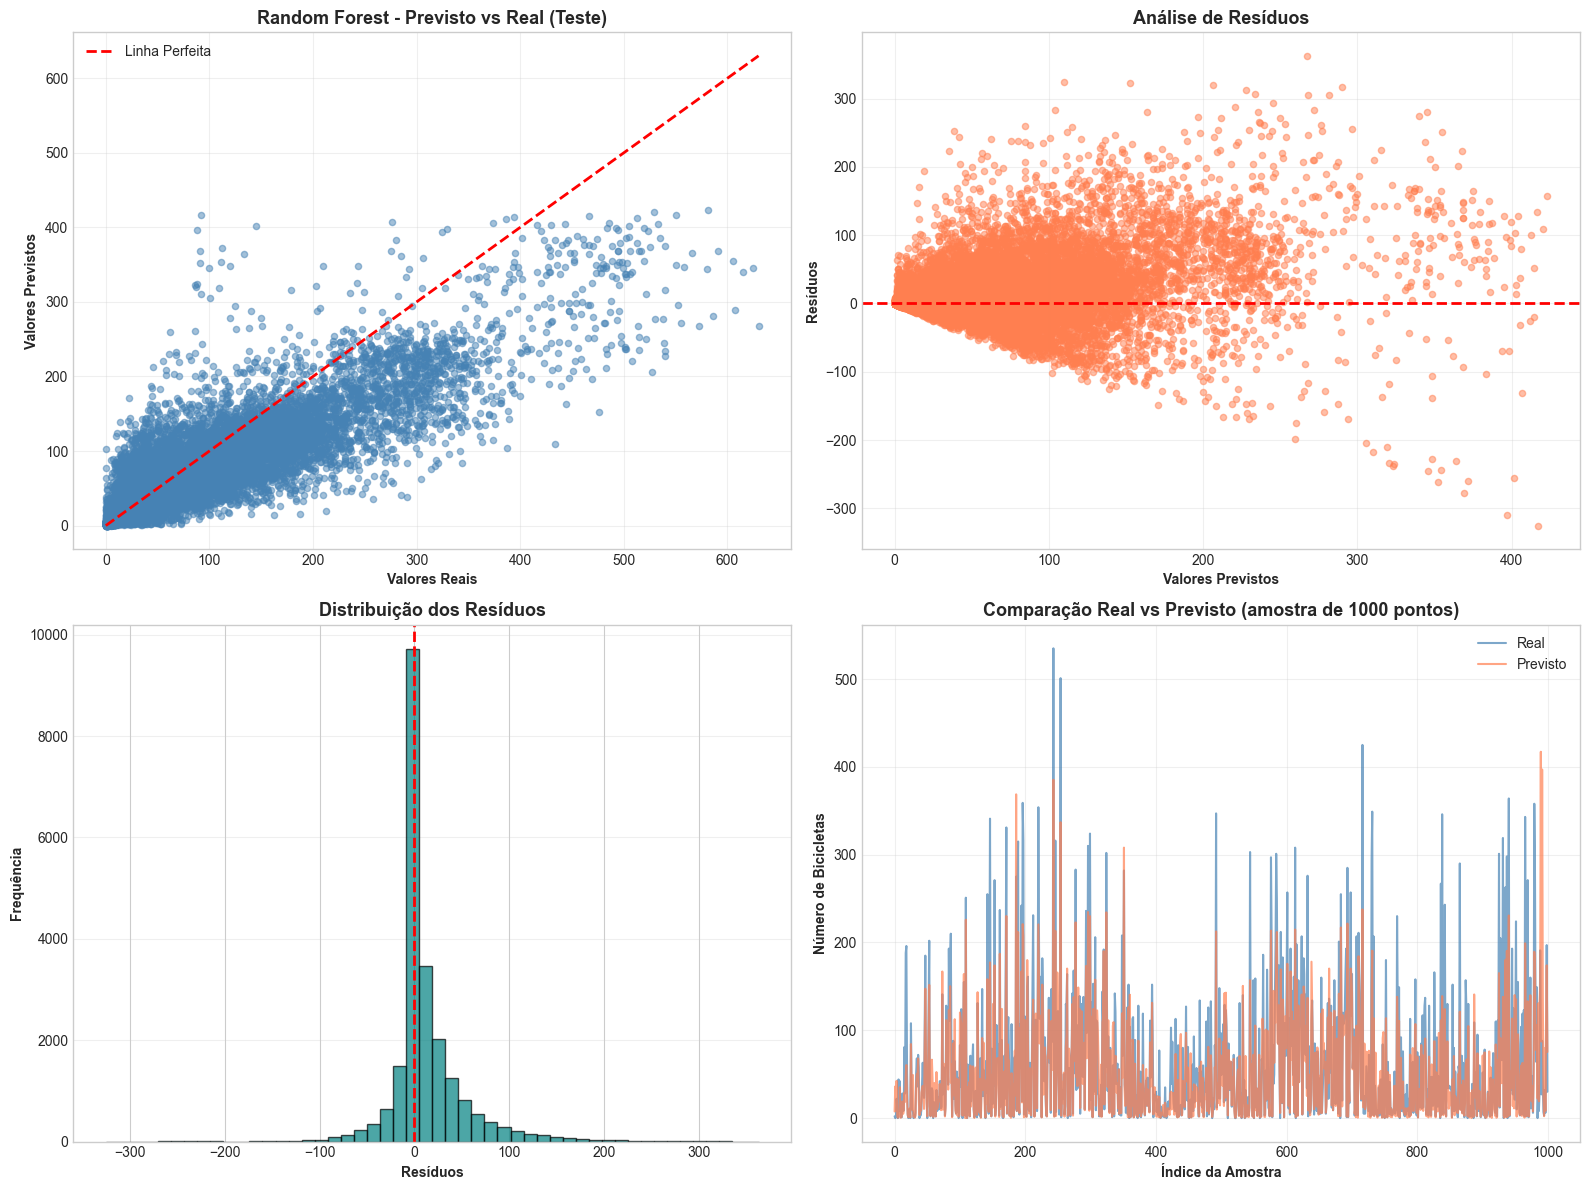


ANÁLISE DE RESÍDUOS - Random Forest
Média dos resíduos: 13.3483
Desvio padrão: 40.2596
Mediana: 2.2900
Min: -325.19, Max: 362.55


In [19]:
# Visualizando previsões do melhor modelo
best_model = results[best_model_name]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Scatter plot (Previsto vs Real) - Teste
axes[0, 0].scatter(y_test, best_model['y_test_pred'], alpha=0.5, s=20, color='steelblue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Linha Perfeita')
axes[0, 0].set_xlabel('Valores Reais', fontweight='bold')
axes[0, 0].set_ylabel('Valores Previstos', fontweight='bold')
axes[0, 0].set_title(f'{best_model_name} - Previsto vs Real (Teste)', fontweight='bold', fontsize=13)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Resíduos
residuals = y_test - best_model['y_test_pred']
axes[0, 1].scatter(best_model['y_test_pred'], residuals, alpha=0.5, s=20, color='coral')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Valores Previstos', fontweight='bold')
axes[0, 1].set_ylabel('Resíduos', fontweight='bold')
axes[0, 1].set_title('Análise de Resíduos', fontweight='bold', fontsize=13)
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Distribuição dos resíduos
axes[1, 0].hist(residuals, bins=50, color='teal', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Resíduos', fontweight='bold')
axes[1, 0].set_ylabel('Frequência', fontweight='bold')
axes[1, 0].set_title('Distribuição dos Resíduos', fontweight='bold', fontsize=13)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Gráfico 4: Série temporal (amostra)
sample_size = min(1000, len(y_test))
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)
sample_indices = np.sort(sample_indices)

axes[1, 1].plot(range(sample_size), y_test.iloc[sample_indices].values, 
                label='Real', color='steelblue', linewidth=1.5, alpha=0.7)
axes[1, 1].plot(range(sample_size), best_model['y_test_pred'][sample_indices], 
                label='Previsto', color='coral', linewidth=1.5, alpha=0.7)
axes[1, 1].set_xlabel('Índice da Amostra', fontweight='bold')
axes[1, 1].set_ylabel('Número de Bicicletas', fontweight='bold')
axes[1, 1].set_title(f'Comparação Real vs Previsto (amostra de {sample_size} pontos)', 
                     fontweight='bold', fontsize=13)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas dos resíduos
print("\n" + "=" * 70)
print(f"ANÁLISE DE RESÍDUOS - {best_model_name}")
print("=" * 70)
print(f"Média dos resíduos: {residuals.mean():.4f}")
print(f"Desvio padrão: {residuals.std():.4f}")
print(f"Mediana: {residuals.median():.4f}")
print(f"Min: {residuals.min():.2f}, Max: {residuals.max():.2f}")
print("=" * 70)

## 11. Análise do Impacto da Variável 'Pandemic'

In [20]:
# Treinando modelo SEM a variável pandemic para comparação
print("Treinando modelo SEM a variável 'pandemic' para comparação...")
print("=" * 70)

# Features sem pandemic
feature_columns_no_pandemic = [col for col in feature_columns if col != 'pandemic']

X_train_no_pandemic = X_train[feature_columns_no_pandemic]
X_test_no_pandemic = X_test[feature_columns_no_pandemic]

# Normalizando
scaler_no_pandemic = StandardScaler()
X_train_no_pandemic_scaled = scaler_no_pandemic.fit_transform(X_train_no_pandemic)
X_test_no_pandemic_scaled = scaler_no_pandemic.transform(X_test_no_pandemic)

# Treinando o melhor modelo SEM pandemic
if best_model_name == 'Random Forest':
    model_no_pandemic = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
elif best_model_name == 'Gradient Boosting':
    model_no_pandemic = GradientBoostingRegressor(n_estimators=100, random_state=42)
elif best_model_name == 'Ridge Regression':
    model_no_pandemic = Ridge(alpha=1.0, random_state=42)
elif best_model_name == 'Lasso Regression':
    model_no_pandemic = Lasso(alpha=1.0, random_state=42)
else:
    model_no_pandemic = LinearRegression()

model_no_pandemic.fit(X_train_no_pandemic_scaled, y_train)
y_test_pred_no_pandemic = model_no_pandemic.predict(X_test_no_pandemic_scaled)

# Métricas SEM pandemic
rmse_no_pandemic = np.sqrt(mean_squared_error(y_test, y_test_pred_no_pandemic))
mae_no_pandemic = mean_absolute_error(y_test, y_test_pred_no_pandemic)
r2_no_pandemic = r2_score(y_test, y_test_pred_no_pandemic)

print(f"\n{best_model_name} - SEM variável 'pandemic':")
print(f"  RMSE: {rmse_no_pandemic:.2f}")
print(f"  MAE: {mae_no_pandemic:.2f}")
print(f"  R²: {r2_no_pandemic:.4f}")

print(f"\n{best_model_name} - COM variável 'pandemic':")
print(f"  RMSE: {best_model['test_rmse']:.2f}")
print(f"  MAE: {best_model['test_mae']:.2f}")
print(f"  R²: {best_model['test_r2']:.4f}")

print("\n" + "=" * 70)
print("IMPACTO DA VARIÁVEL 'PANDEMIC':")
print("=" * 70)
rmse_improvement = ((rmse_no_pandemic - best_model['test_rmse']) / rmse_no_pandemic) * 100
mae_improvement = ((mae_no_pandemic - best_model['test_mae']) / mae_no_pandemic) * 100
r2_improvement = ((best_model['test_r2'] - r2_no_pandemic) / abs(r2_no_pandemic)) * 100

print(f"Melhoria no RMSE: {rmse_improvement:+.2f}%")
print(f"Melhoria no MAE: {mae_improvement:+.2f}%")
print(f"Melhoria no R²: {r2_improvement:+.2f}%")

if rmse_improvement > 0:
    print(f"\n✓ A inclusão da variável 'pandemic' MELHOROU o modelo!")
else:
    print(f"\n✗ A inclusão da variável 'pandemic' NÃO melhorou significativamente o modelo.")
    
print("=" * 70)

Treinando modelo SEM a variável 'pandemic' para comparação...

Random Forest - SEM variável 'pandemic':
  RMSE: 42.38
  MAE: 23.47
  R²: 0.7382

Random Forest - COM variável 'pandemic':
  RMSE: 42.41
  MAE: 23.48
  R²: 0.7377

IMPACTO DA VARIÁVEL 'PANDEMIC':
Melhoria no RMSE: -0.08%
Melhoria no MAE: -0.05%
Melhoria no R²: -0.06%

✗ A inclusão da variável 'pandemic' NÃO melhorou significativamente o modelo.

Random Forest - SEM variável 'pandemic':
  RMSE: 42.38
  MAE: 23.47
  R²: 0.7382

Random Forest - COM variável 'pandemic':
  RMSE: 42.41
  MAE: 23.48
  R²: 0.7377

IMPACTO DA VARIÁVEL 'PANDEMIC':
Melhoria no RMSE: -0.08%
Melhoria no MAE: -0.05%
Melhoria no R²: -0.06%

✗ A inclusão da variável 'pandemic' NÃO melhorou significativamente o modelo.


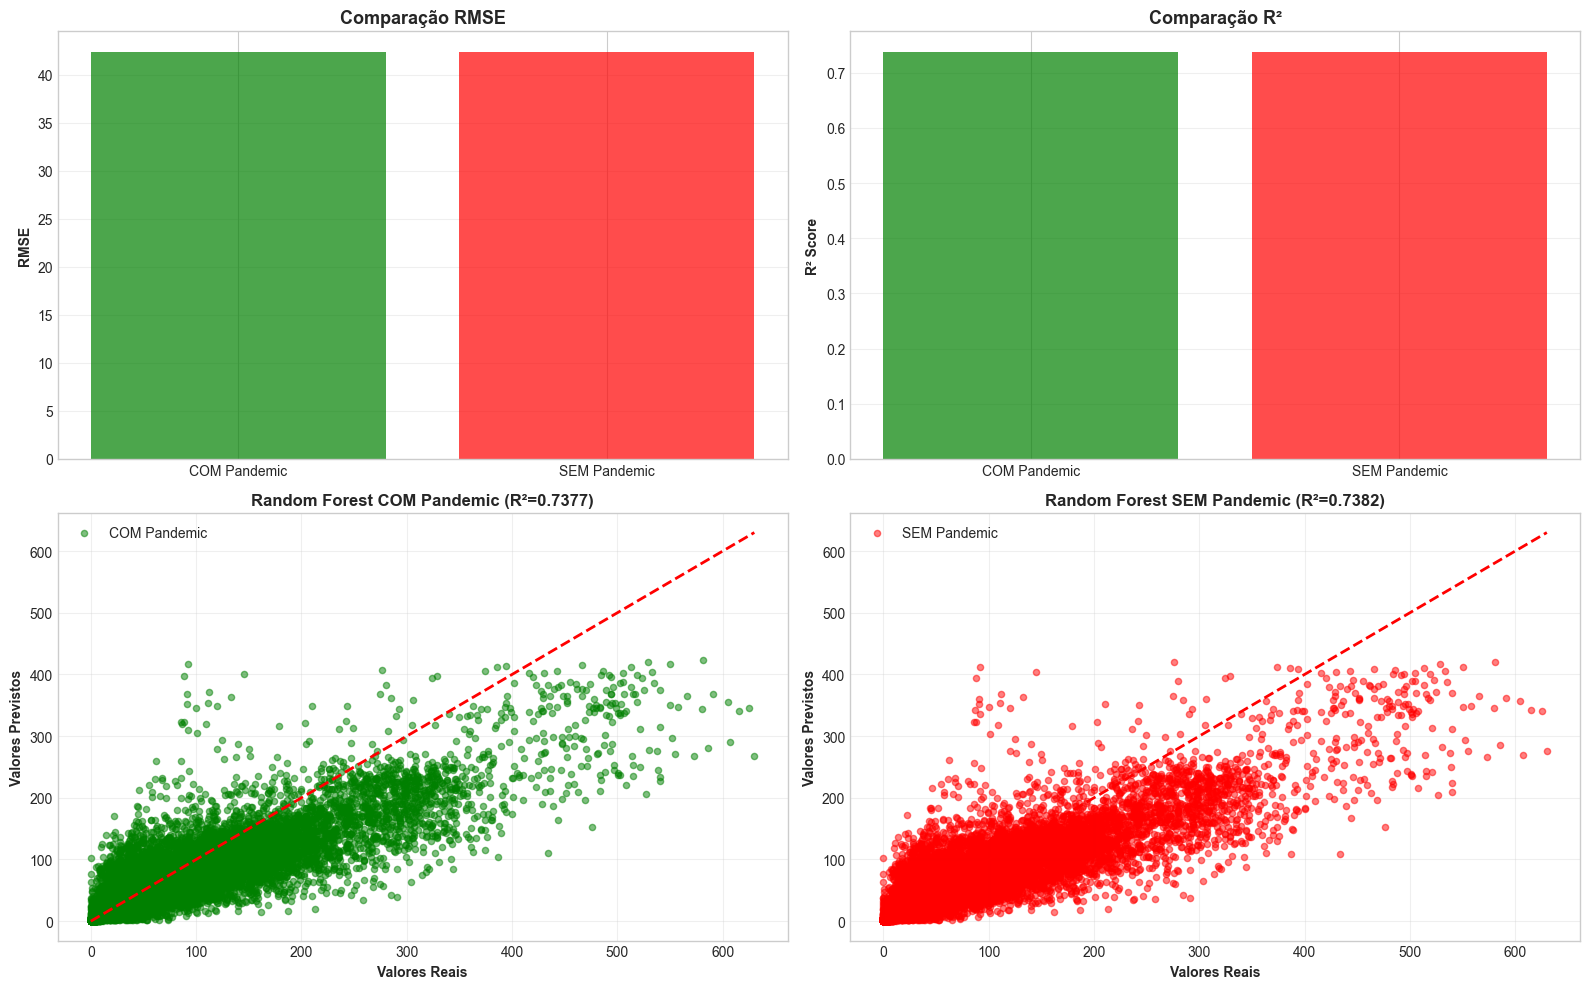

In [21]:
# Visualização comparativa COM vs SEM pandemic
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Gráfico 1: Comparação de métricas
metrics_comparison = {
    'RMSE': [best_model['test_rmse'], rmse_no_pandemic],
    'MAE': [best_model['test_mae'], mae_no_pandemic],
    'R²': [best_model['test_r2'], r2_no_pandemic]
}

x = np.arange(len(metrics_comparison))
width = 0.35

for idx, (metric_name, values) in enumerate(metrics_comparison.items()):
    ax = axes[0, 0] if idx < 2 else axes[0, 1]
    if idx == 2:
        ax = axes[0, 1]
    
axes[0, 0].bar([0, 1], [best_model['test_rmse'], rmse_no_pandemic], 
               color=['green', 'red'], alpha=0.7)
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['COM Pandemic', 'SEM Pandemic'])
axes[0, 0].set_ylabel('RMSE', fontweight='bold')
axes[0, 0].set_title('Comparação RMSE', fontweight='bold', fontsize=13)
axes[0, 0].grid(True, alpha=0.3, axis='y')

axes[0, 1].bar([0, 1], [best_model['test_r2'], r2_no_pandemic], 
               color=['green', 'red'], alpha=0.7)
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['COM Pandemic', 'SEM Pandemic'])
axes[0, 1].set_ylabel('R² Score', fontweight='bold')
axes[0, 1].set_title('Comparação R²', fontweight='bold', fontsize=13)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Gráfico 2: Scatter COM pandemic
axes[1, 0].scatter(y_test, best_model['y_test_pred'], alpha=0.5, s=20, color='green', label='COM Pandemic')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2)
axes[1, 0].set_xlabel('Valores Reais', fontweight='bold')
axes[1, 0].set_ylabel('Valores Previstos', fontweight='bold')
axes[1, 0].set_title(f'{best_model_name} COM Pandemic (R²={best_model["test_r2"]:.4f})', 
                     fontweight='bold', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 3: Scatter SEM pandemic
axes[1, 1].scatter(y_test, y_test_pred_no_pandemic, alpha=0.5, s=20, color='red', label='SEM Pandemic')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2)
axes[1, 1].set_xlabel('Valores Reais', fontweight='bold')
axes[1, 1].set_ylabel('Valores Previstos', fontweight='bold')
axes[1, 1].set_title(f'{best_model_name} SEM Pandemic (R²={r2_no_pandemic:.4f})', 
                     fontweight='bold', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()